## Load the weights and configuration file

In [19]:
import cv2 
import numpy as np
net = cv2.dnn.readNet('/Users/amariofausta/Documents/Kuliah/Semester 8/Bobot/yolov3custom_last.weights copy 5','/Users/amariofausta/Downloads/yolov3custom2.cfg')
with open("/Users/amariofausta/Documents/Kuliah/Semester 8/Dataset/dataset/classes.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

## APPLY YOLOv3 Model to the videos

In [20]:
import time
import sys
import matplotlib.pyplot as plt

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
measurement_data = []
jumlah_frame = 0
detik = 0
Pembatas = []
Pembatas_bawah = 0
frame_count = 0
catatan_waktu1 = []
catatan_waktu2 = []
posisi_bola = []
frame_bola = []
start_time_keseluruhan = time.time()

# Start video capture from webcam
cap = cv2.VideoCapture('/Users/amariofausta/Documents/Kuliah/Semester 8/Video mentah/60 cm part 3.mp4')
while True:
    try:
        # Read a frame from the video capture
        ret, frame = cap.read()
        
        # Create a blob from the input image
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        
        # Pass the blob through the network and get the outputs
        net.setInput(blob)
        outputs = net.forward(output_layers)
        
        # Process the outputs to get the detected objects
        class_ids = []
        confidences = []
        boxes = []
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.4:
                    # Object detected
                    center_x = int(detection[0] * frame.shape[1])
                    center_y = int(detection[1] * frame.shape[0])
                    width = int(detection[2] * frame.shape[1])
                    height = int(detection[3] * frame.shape[0])
                    x = int(center_x - width / 2)
                    y = int(center_y - height / 2)
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, width, height])
            
        # Apply non-maximum suppression to remove redundant detections
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)
        # Draw the detected objects on the image
        for i in indices:
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            measurement_data.append([y, classes[class_ids[i]]])
            cv2.putText(frame, classes[class_ids[i]], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            #print(boxes[i],classes[class_ids[i]])

            #Mengetahui pembatas atas dan bawah
            if classes[class_ids[i]] == 'Pembatas':
                Pembatas.append(boxes[i])
            if len(Pembatas) == 2:
                if Pembatas[0][1] > Pembatas[1][1]:
                    Pembatas_atas = Pembatas[1][1]
                    Pembatas_bawah = Pembatas[0][1]
                elif Pembatas[0][1] < Pembatas[1][1]:
                    Pembatas_atas = Pembatas[0][1]
                    Pembatas_bawah = Pembatas[1][1]

            if classes[class_ids[i]] == 'Bola':
                posisi_bola.append(boxes[i][1])
                frame_bola.append(jumlah_frame)
                if len(Pembatas) > 2:
                    if boxes[i][1] >= Pembatas_atas and boxes[i][1] <= Pembatas_bawah:
                        catatan_waktu1.append(time.time())
                    if boxes[i][1] >= Pembatas_bawah:
                        catatan_waktu2.append(time.time())

        # Display the output image
        cv2.imshow("Output", frame)
        frame_count += 1
        jumlah_frame += 1
        
        end_time_keseluruhan = time.time()
        elapsed_time = end_time_keseluruhan - start_time_keseluruhan
        if elapsed_time > 1:
            fps = frame_count / elapsed_time
            frame_count = 0
            start_time_keseluruhan = time.time()
            print(fps)
        # Wait for a key press to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except:
        break        


# Release resources
cap.release()
cv2.destroyAllWindows()

1.2110987975936858
5.509621434735948
5.106512705902501
5.453454937170845
5.7500066260573135
5.610456040567854
5.681752789871662
5.709951667233143
5.94616797203207


## Track the coordinates of each sensors

In [21]:
print('Coordinate of the upper sensor in the Y-axis (pixels) :', Pembatas_atas)
print('Coordinate of the lower sensor in the Y-axis (pixels) :', Pembatas_bawah)

Coordinate of the upper sensor in the Y-axis (pixels) : 694
Coordinate of the lower sensor in the Y-axis (pixels) : 1535


## Track the ball coordinate

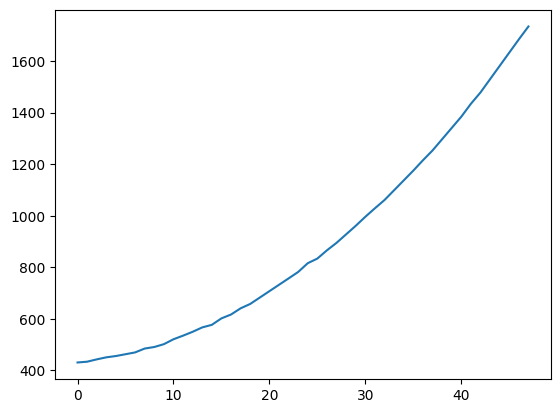

In [22]:
plt.plot(frame_bola, posisi_bola)

## Measure fall time of the ball

In [23]:
waktu_jatuh = catatan_waktu2[0] - catatan_waktu1[0]
waktu_jatuh = waktu_jatuh/(120/fps)
print('The fall time of the ball :', waktu_jatuh)

The fall time of the ball : 0.20839256466260708


## Calculate the acceleration of the ball

In [24]:
percepatan_gravitasi = 0.6/((0.2*waktu_jatuh) + (0.5*waktu_jatuh*waktu_jatuh))
print(percepatan_gravitasi)

9.464880362014068


In [25]:
import csv

A = frame_bola
B = posisi_bola

# Menyimpan data ke dalam file CSV
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Urutan frame', 'Posisi bola relatif terhadap sumbu y'])  # Menulis header
    writer.writerows(zip(A, B))  # Menulis data